In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vamshikrishnasunnam","key":"5af6648a4fe664fe8c08ce73a5927dbb"}'}

In [3]:
!kaggle competitions download -c dogs-vs-cats

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
!kaggle competitions download -c dogs-vs-cats

100% 809M/812M [00:07<00:00, 254MB/s]
100% 812M/812M [00:07<00:00, 121MB/s]


In [6]:
!unzip -qq dogs-vs-cats.zip

In [7]:
!unzip -qq train.zip

In [8]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=500)
make_subset("validation", start_index=1000, end_index=1250)
make_subset("test", start_index=1500, end_index=1750)

In [9]:
# Import necessary libraries
import os
import shutil
import pathlib

# Define the original directory containing the training data
original_dir = pathlib.Path("train")

# Define the new base directory where you want to create subsets of the data
new_base_dir = pathlib.Path("cats_vs_dogs_small")

# Function to create a subset of data
def make_subset(subset_name, start_index, end_index):
    # Loop through categories ("cat" and "dog")
    for category in ("cat", "dog"):
        # Create a directory for the current category within the subset
        dir = new_base_dir / subset_name / category
        dir.mkdir(parents=True, exist_ok=True)

        # Generate a list of filenames for the current category and index range
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]

        # Copy the selected files from the original directory to the subset directory
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

# Create subsets of the data using the make_subset function
make_subset("train", start_index=0, end_index=500)         # Create a training subset
make_subset("validation", start_index=1000, end_index=1250)  # Create a validation subset
make_subset("test", start_index=1500, end_index=1750)       # Create a test subset

In [10]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 1000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [11]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [12]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [13]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 30ms/step


In [14]:
train_features.shape

(1000, 5, 5, 512)

**VGG - Model 1 Dense Layer with 256 Nodes and Droput Rate of 0.5 and optimizer being rmsprop with the Original Images**

In [15]:
# Defining and Training the densely connected classifier
# The last dense stacked layer and the classifier
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)


# Compiling the Model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


# Saving the results of the model
callbacks = [
keras.callbacks.ModelCheckpoint(
    filepath="vgg_model1.keras",
    save_best_only=True,
    monitor="val_loss",
    save_format="tf")
]


# Model Fit
VGG_Model_1 = model.fit(
              train_features, train_labels,
              epochs= 30,
              validation_data= (val_features, val_labels),
              callbacks= callbacks)

Epoch 1/30
32/32 [==============================] - 5s 15ms/step - loss: 27.8372 - accuracy: 0.9080 - val_loss: 3.7791 - val_accuracy: 0.9580
Epoch 2/30
32/32 [==============================] - 0s 6ms/step - loss: 2.4016 - accuracy: 0.9780 - val_loss: 10.1437 - val_accuracy: 0.9520
Epoch 3/30
32/32 [==============================] - 0s 6ms/step - loss: 2.2340 - accuracy: 0.9860 - val_loss: 6.0214 - val_accuracy: 0.9620
Epoch 4/30
32/32 [==============================] - 0s 6ms/step - loss: 0.9135 - accuracy: 0.9910 - val_loss: 6.3927 - val_accuracy: 0.9640
Epoch 5/30
32/32 [==============================] - 0s 6ms/step - loss: 1.4750 - accuracy: 0.9900 - val_loss: 6.8895 - val_accuracy: 0.9680
Epoch 6/30
32/32 [==============================] - 0s 6ms/step - loss: 0.2155 - accuracy: 0.9980 - val_loss: 6.5449 - val_accuracy: 0.9700
Epoch 7/30
32/32 [==============================] - 0s 5ms/step - loss: 0.7136 - accuracy: 0.9940 - val_loss: 6.7580 - val_accuracy: 0.9660
Epoch 8/30
32/32 

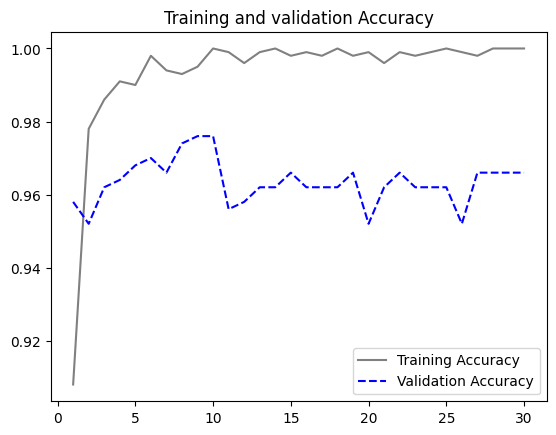

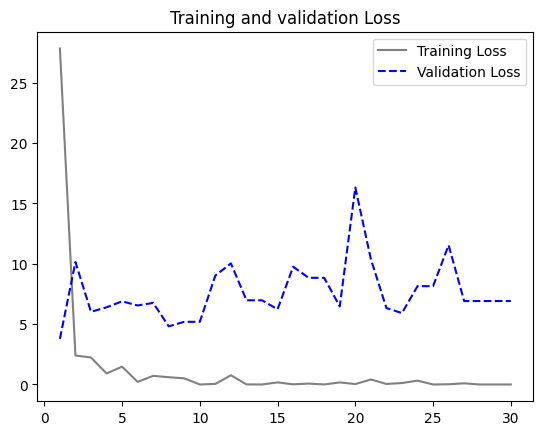

In [16]:
acc = VGG_Model_1.history["accuracy"]
val_acc = VGG_Model_1.history["val_accuracy"]

loss = VGG_Model_1.history["loss"]
val_loss = VGG_Model_1.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color="grey", label="Training Accuracy")
plt.plot(epochs, val_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and validation Loss")
plt.legend()
plt.show()

In [17]:
best_model = keras.models.load_model("vgg_model1.keras")
VGG_Model_1_Results = best_model.evaluate(test_features,test_labels)
print(f'Loss: {VGG_Model_1_Results[0]:.3f}')
print(f'Accuracy: {VGG_Model_1_Results[1]:.3f}')

16/16 [==============================] - 0s 3ms/step - loss: 4.5313 - accuracy: 0.9600
Loss: 4.531
Accuracy: 0.960


VGG Model 2

In [18]:
conv_base= keras.applications.vgg16.VGG16(
           weights="imagenet",
           include_top=False)

conv_base.trainable = False

We are freezing the pre-trained model during training, so that only the densely connected networks and the classifier update their weights. This helps to prevent overfitting, especially when we have a small training dataset and limited computational resources.

Freezing the pre-trained model means that its weights are not updated during training. This is useful because the pre-trained model has already learned to extract useful features from images, so we don't want to overwrite this knowledge. Instead, we want to focus on training the densely connected networks and the classifier to learn how to combine these features to classify images accurately.

In [19]:
# Before Freezing
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [20]:
# After Freezing
#by setting the trainable to false we are freezing the con base to 0
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [21]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**VGG - Model 2 Dense Layer with 256 Nodes and Droput Rate of 0.5 and optimizer being rmsprop with the Augmented Images**

In [22]:
# Data Augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# Adding the Classifier and Dense Network
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

In [23]:
# Compiling the Model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


# Saving the results of the model
callbacks = [
keras.callbacks.ModelCheckpoint(
    filepath="model2.tf",
    save_best_only=True,
    monitor="val_loss",
    save_format="tf")
]


# Model Fit
VGG_Model_2 = model.fit(
              train_dataset,
              epochs= 30,
              validation_data=validation_dataset,
              callbacks=callbacks)

Epoch 1/30
32/32 [==============================] - 11s 277ms/step - loss: 30.5492 - accuracy: 0.8680 - val_loss: 3.2868 - val_accuracy: 0.9700
Epoch 2/30
32/32 [==============================] - 5s 141ms/step - loss: 5.4791 - accuracy: 0.9500 - val_loss: 9.6068 - val_accuracy: 0.9400
Epoch 3/30
32/32 [==============================] - 5s 150ms/step - loss: 5.2214 - accuracy: 0.9570 - val_loss: 6.7466 - val_accuracy: 0.9700
Epoch 4/30
32/32 [==============================] - 8s 233ms/step - loss: 5.1218 - accuracy: 0.9620 - val_loss: 2.9987 - val_accuracy: 0.9720
Epoch 5/30
32/32 [==============================] - 5s 142ms/step - loss: 4.0248 - accuracy: 0.9680 - val_loss: 5.2766 - val_accuracy: 0.9720
Epoch 6/30
32/32 [==============================] - 6s 174ms/step - loss: 1.8488 - accuracy: 0.9830 - val_loss: 3.5711 - val_accuracy: 0.9680
Epoch 7/30
32/32 [==============================] - 5s 145ms/step - loss: 3.0961 - accuracy: 0.9690 - val_loss: 8.7636 - val_accuracy: 0.9660
Epoc

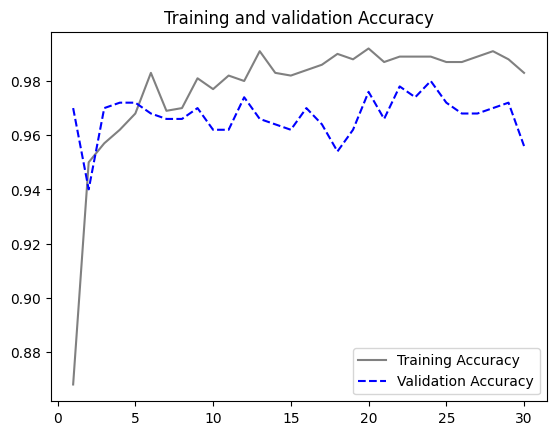

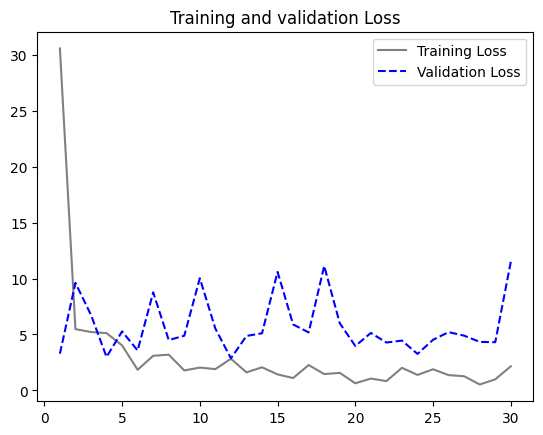

In [24]:
acc = VGG_Model_2.history["accuracy"]
val_acc = VGG_Model_2.history["val_accuracy"]

loss = VGG_Model_2.history["loss"]
val_loss = VGG_Model_2.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color="grey", label="Training Accuracy")
plt.plot(epochs, val_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and validation Loss")
plt.legend()
plt.show()


In [25]:

test_model = keras.models.load_model("model2.tf")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'Loss: {test_loss:.3f}')
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 2s 94ms/step - loss: 6.3765 - accuracy: 0.9680
Loss: 6.376
Test accuracy: 0.968


**Fine Tuning the VGG_Model_2**

In [26]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [27]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])


# Saving the results of the model
callbacks = [
keras.callbacks.ModelCheckpoint(
    filepath="finemodel2.tf",
    save_best_only=True,
    monitor="val_loss",
    save_format="tf")
]


FineTuned_VGG_Model_2 = model.fit(
                        train_dataset,
                        epochs=30,
                        validation_data=validation_dataset,
                        callbacks=callbacks)

Epoch 1/30
32/32 [==============================] - 12s 256ms/step - loss: 0.9360 - accuracy: 0.9870 - val_loss: 5.2214 - val_accuracy: 0.9680
Epoch 2/30
32/32 [==============================] - 10s 306ms/step - loss: 0.8605 - accuracy: 0.9910 - val_loss: 4.9063 - val_accuracy: 0.9700
Epoch 3/30
32/32 [==============================] - 8s 245ms/step - loss: 0.5385 - accuracy: 0.9930 - val_loss: 4.2181 - val_accuracy: 0.9680
Epoch 4/30
32/32 [==============================] - 6s 177ms/step - loss: 0.3612 - accuracy: 0.9970 - val_loss: 4.7155 - val_accuracy: 0.9720
Epoch 5/30
32/32 [==============================] - 5s 161ms/step - loss: 0.1603 - accuracy: 0.9940 - val_loss: 8.3072 - val_accuracy: 0.9620
Epoch 6/30
32/32 [==============================] - 7s 196ms/step - loss: 0.2716 - accuracy: 0.9980 - val_loss: 4.4952 - val_accuracy: 0.9740
Epoch 7/30
32/32 [==============================] - 5s 162ms/step - loss: 0.4090 - accuracy: 0.9940 - val_loss: 4.3427 - val_accuracy: 0.9720
Epoc

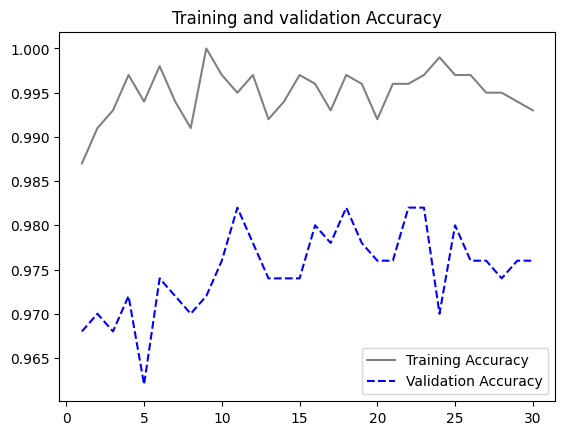

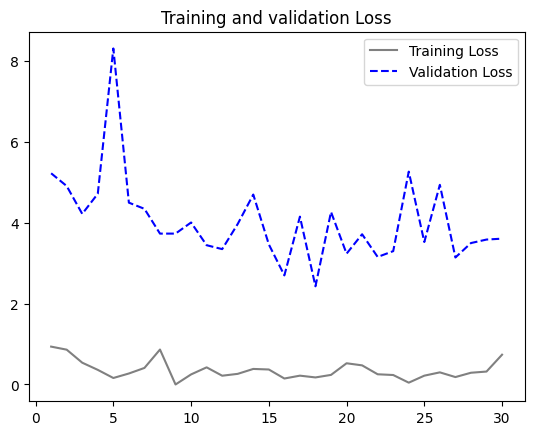

In [28]:
acc = FineTuned_VGG_Model_2.history["accuracy"]
val_acc = FineTuned_VGG_Model_2.history["val_accuracy"]

loss = FineTuned_VGG_Model_2.history["loss"]
val_loss = FineTuned_VGG_Model_2.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color="grey", label="Training Accuracy")
plt.plot(epochs, val_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and validation Loss")
plt.legend()
plt.show()

In [29]:
test_model = keras.models.load_model("finemodel2.tf")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'Loss: {test_loss:.3f}')
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 2s 97ms/step - loss: 6.3860 - accuracy: 0.9640
Loss: 6.386
Test accuracy: 0.964


We are going to experiment with two different ways to freeze the pre-trained VGG16 network when training with 5000 training samples. We will compare the accuracy of these models to the baseline model that we trained without freezing the pre-trained network.

Freezing the pre-trained network is a common technique used to improve the performance of convnets, especially when we have a small training dataset. By freezing the pre-trained network, we prevent it from overfitting to the training data and allow it to focus on learning general features that can be used to classify new images.

**VGG - Model 3 (5000 Training Samples)**

In [30]:
conv_base= keras.applications.vgg16.VGG16(
           weights="imagenet",
           include_top=False)

conv_base.trainable = False

In [31]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [32]:
# Import necessary libraries
import os
import shutil
import pathlib

# Define the original directory containing the training data
original_dir = pathlib.Path("train")

# Define the new base directory where you want to create subsets of the data
new_base_dir = pathlib.Path("cats_vs_dogs_3")

# Function to create a subset of data
def make_subset(subset_name, start_index, end_index):
    # Loop through categories ("cat" and "dog")
    for category in ("cat", "dog"):
        # Create a directory for the current category within the subset
        dir = new_base_dir / subset_name / category
        dir.mkdir(parents=True, exist_ok=True)

        # Generate a list of filenames for the current category and index range
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]

        # Copy the selected files from the original directory to the subset directory
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

# Create subsets of the data using the make_subset function
make_subset("train", start_index=0, end_index=2500)         # Create a training subset
make_subset("validation", start_index=1000, end_index=1250)  # Create a validation subset
make_subset("test", start_index=1500, end_index=1750)       # Create a test subset

In [33]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 5000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


**VGG - Model 3 Dense Layer with 256 Nodes and Droput Rate of 0.5 and optimizer being adam with the augmented Images**

In [34]:
# Data Augmentation
data_augmentation_4 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.25),
    ]
)

# Adding the Classifier and Dense Network
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_4(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

In [35]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


# Saving the results of the model
callbacks = [
keras.callbacks.ModelCheckpoint(
    filepath="model3.tf",
    save_best_only=True,
    monitor="val_loss",
    save_format="tf")
]


# Model Fit
VGG_Model_3 = model.fit(
              train_dataset,
              epochs= 50,
              validation_data=validation_dataset,
              callbacks=callbacks)

Epoch 1/50
157/157 [==============================] - 23s 134ms/step - loss: 10.3449 - accuracy: 0.9220 - val_loss: 2.7331 - val_accuracy: 0.9800
Epoch 2/50
157/157 [==============================] - 18s 113ms/step - loss: 6.8249 - accuracy: 0.9406 - val_loss: 3.1479 - val_accuracy: 0.9840
Epoch 3/50
157/157 [==============================] - 22s 137ms/step - loss: 5.3331 - accuracy: 0.9428 - val_loss: 1.7476 - val_accuracy: 0.9780
Epoch 4/50
157/157 [==============================] - 20s 128ms/step - loss: 3.3872 - accuracy: 0.9526 - val_loss: 0.4769 - val_accuracy: 0.9880
Epoch 5/50
157/157 [==============================] - 21s 131ms/step - loss: 1.7448 - accuracy: 0.9616 - val_loss: 0.1782 - val_accuracy: 0.9920
Epoch 6/50
157/157 [==============================] - 18s 113ms/step - loss: 1.2971 - accuracy: 0.9626 - val_loss: 0.3097 - val_accuracy: 0.9840
Epoch 7/50
157/157 [==============================] - 21s 131ms/step - loss: 0.6697 - accuracy: 0.9578 - val_loss: 0.1133 - val_a

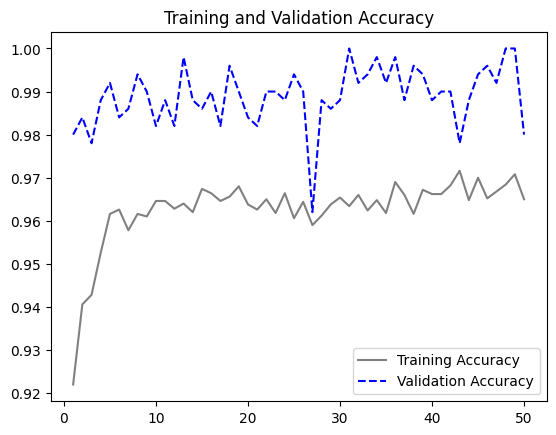

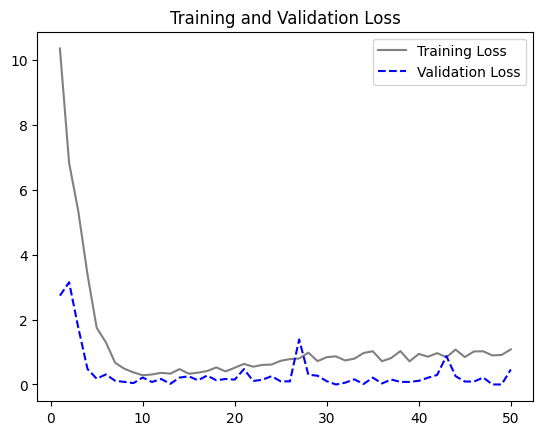

In [36]:
acc = VGG_Model_3.history["accuracy"]
val_acc = VGG_Model_3.history["val_accuracy"]

loss = VGG_Model_3.history["loss"]
val_loss = VGG_Model_3.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color="grey", label="Training Accuracy")
plt.plot(epochs, val_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [37]:
test_model = keras.models.load_model("model3.tf")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'Loss: {test_loss:.3f}')
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 2s 95ms/step - loss: 0.2891 - accuracy: 0.9940
Loss: 0.289
Test accuracy: 0.994


**Fine Tunning VGG_Model_3 (Training Samples - 5000)**

We are optimizing VGG_Model3 by freezing the first four layers. This will prevent the model from overfitting and allow it to learn features that are specific to our classification task. We are also setting the pre-trained layers to not update during training. These optimizations are designed to improve the performance of the model with 5000 training samples

In [38]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [39]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"])


# Saving the results of the model
callbacks = [
keras.callbacks.ModelCheckpoint(
    filepath="fine_vgg_model3.tf",
    save_best_only=True,
    monitor="val_loss",
    save_format="tf")
]



FineTuned_VGG_Model_3 = model.fit(
                        train_dataset,
                        epochs=50,
                        validation_data=validation_dataset,
                        callbacks=callbacks)

Epoch 1/50
157/157 [==============================] - 28s 158ms/step - loss: 0.8699 - accuracy: 0.9710 - val_loss: 0.1921 - val_accuracy: 0.9980
Epoch 2/50
157/157 [==============================] - 23s 148ms/step - loss: 0.5794 - accuracy: 0.9752 - val_loss: 0.1368 - val_accuracy: 0.9960
Epoch 3/50
157/157 [==============================] - 27s 173ms/step - loss: 0.3817 - accuracy: 0.9800 - val_loss: 0.0559 - val_accuracy: 0.9960
Epoch 4/50
157/157 [==============================] - 24s 148ms/step - loss: 0.3971 - accuracy: 0.9776 - val_loss: 0.0497 - val_accuracy: 0.9960
Epoch 5/50
157/157 [==============================] - 26s 167ms/step - loss: 0.3292 - accuracy: 0.9792 - val_loss: 0.0182 - val_accuracy: 0.9980
Epoch 6/50
157/157 [==============================] - 20s 127ms/step - loss: 0.2397 - accuracy: 0.9796 - val_loss: 0.0306 - val_accuracy: 0.9980
Epoch 7/50
157/157 [==============================] - 21s 129ms/step - loss: 0.2044 - accuracy: 0.9802 - val_loss: 0.0926 - val_ac

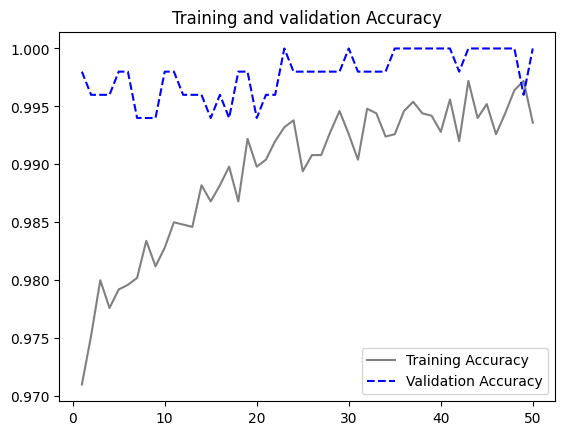

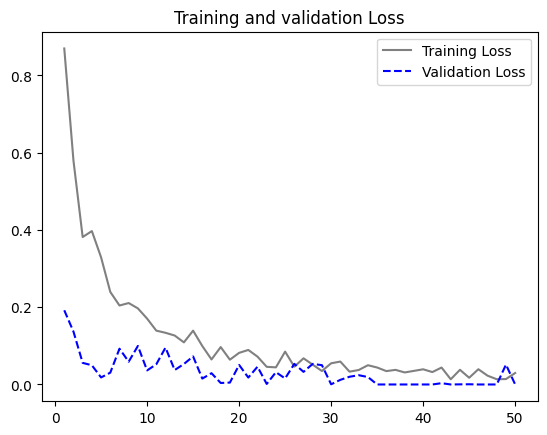

In [40]:
acc = FineTuned_VGG_Model_3.history["accuracy"]
val_acc = FineTuned_VGG_Model_3.history["val_accuracy"]

loss = FineTuned_VGG_Model_3.history["loss"]
val_loss = FineTuned_VGG_Model_3.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color="grey", label="Training Accuracy")
plt.plot(epochs, val_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and validation Loss")
plt.legend()
plt.show()

In [41]:
test_model = keras.models.load_model("fine_vgg_model3.tf")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'Loss: {test_loss:.3f}')
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 2s 99ms/step - loss: 0.0072 - accuracy: 0.9980
Loss: 0.007
Test accuracy: 0.998


In [44]:
# Pre-Trained Models
VGG_Model_1 = (4.531,0.960)
VGG_Model_2 = (6.376,0.968)
FineTuned_VGG_Model_2 = (6.386,0.964)
VGG_Model_3 = (0.289,0.994)
FineTuned_VGG_Model_3 = (0.007,0.998)

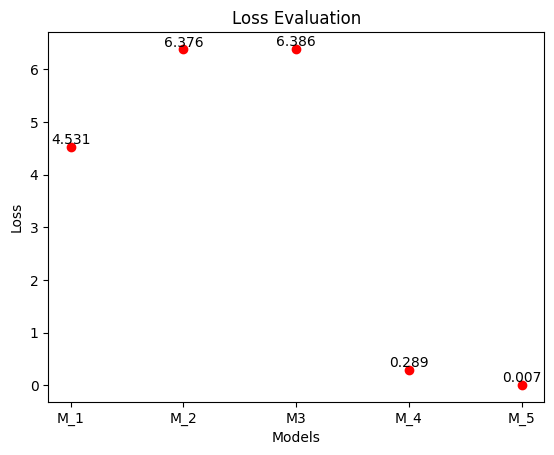

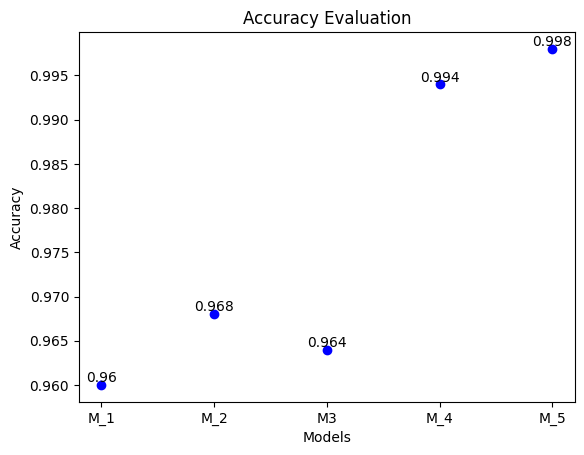

In [45]:
Models = ("M_1","M_2","M3","M_4","M_5")
VGG_Loss = (VGG_Model_1[0], VGG_Model_2[0],FineTuned_VGG_Model_2[0],VGG_Model_3[0],FineTuned_VGG_Model_3[0])
VGG_Accuracy = (VGG_Model_1[1], VGG_Model_2[1],FineTuned_VGG_Model_2[1],VGG_Model_3[1],FineTuned_VGG_Model_3[1])

# Loss Evaluation
plt.scatter(Models, VGG_Loss, color="red")
plt.title("Loss Evaluation")
plt.xlabel("Models")
plt.ylabel("Loss")

for (xi, yi) in zip(Models,VGG_Loss):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()

# Accuracy Evaluation
plt.scatter(Models, VGG_Accuracy, color="blue")
plt.title("Accuracy Evaluation")
plt.xlabel("Models")
plt.ylabel("Accuracy")

for (xi, yi) in zip(Models,VGG_Accuracy):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()
